## Project Definition

**Project Link:** [Semantic Layer for UCI Diabetes Dataset](https://github.com/isihack/Semantic-Layers-LLM)

**Challenge:**  
Healthcare datasets, such as the UCI Diabetes dataset, are rich in information but difficult to explore without strong data analysis skills. Column names can be cryptic, categorical values unclear, and relationships between features complex. This creates a barrier for non-technical stakeholders who need insights quickly. Our challenge is to enable **LLM-powered**, natural language–driven exploration and analysis of this dataset, making advanced analytics accessible without writing code.

**Data Description:**  
We use the **UCI Diabetes 130-US hospitals dataset (1999–2008)**, containing over 100,000 patient encounter records. It includes patient demographics, diagnoses, laboratory test results, treatment details, medication use, and readmission outcomes. The dataset is provided in a structured CSV format with both numerical and categorical features.

**Machine Learning & LLM Integration:**  
This project uses **Supervised Learning** for **multiclass classification** (predicting readmission status: `<30 days`, `>30 days`, or `No readmission`) and regression tasks (predicting length of stay). It integrates a **Large Language Model (LLM)** — GPT-4o-mini — with a **semantic layer** to interpret user questions, generate executable Pandas/Matplotlib/Scikit-learn code, and return insights or visualizations in real time.


In [ ]:
import json, re
import pandas as pd

# Load data & semantic layer
df = pd.read_csv("diabetic_data.csv")
sem = json.load(open("semantic_layer.json"))

# Simple resolver: map user terms to canonical columns via synonyms
alias_map = {**{k: v for k, v in sem["synonyms"].items()}, **{c: c for c in sem["columns"].keys()}}

def resolve_column(term: str):
    t = re.sub(r"[^a-z0-9_]+","", term.lower())
    return alias_map.get(t)

def nl_query(prompt: str):
    prompt_l = prompt.lower()

    if "average" in prompt_l and ("length of stay" in prompt_l or "los" in prompt_l or "time in hospital" in prompt_l):
        col = "time_in_hospital"
        return {"type": "aggregation", "result": df[col].mean(), "explain": f"Computed mean({col})."}
    if "top" in prompt_l and "specialty" in prompt_l:
        col = "medical_specialty"
        return {"type": "topk", "result": df[col].value_counts().head(10), "explain": f"Top-10 {col} by frequency."}
    if "readmitted" in prompt_l and ("within 30" in prompt_l or "<30" in prompt_l):
        col = "readmitted"
        filt = df[col].eq("<30")
        return {"type": "filter_count", "result": int(filt.sum()), "explain": f"Count where {col} == '<30'."}
    return {"type":"fallback","message":"Handler not implemented yet — teach me a pattern."}

print(nl_query("What is the average length of stay?"))


{'type': 'aggregation', 'result': 4.395986871843248, 'explain': 'Computed mean(time_in_hospital).'}


In [ ]:
from openai import OpenAI
import pandas as pd
import json

# Load data and semantic layer
df = pd.read_csv("diabetic_data.csv")
semantic_layer = json.load(open("semantic_layer.json"))

# Init OpenAI client
client = OpenAI(api_key="OPENAI_API_KEY")

# Helper: Build the prompt with semantic layer context
def build_prompt(user_query):
    return f"""
You are a Python data analysis assistant.
You have access to a Pandas DataFrame called `df` loaded from the Diabetic Data CSV.
Here is the schema and semantic layer:

{json.dumps(semantic_layer, indent=2)}

Task:
- Interpret the user's query.
- Generate valid Python code (Pandas + matplotlib if needed) to answer it.
- Only use columns that exist in the schema.
- Do not drop or rename columns unless explicitly asked.
- If plotting, use matplotlib, one figure per plot, no style overrides.

User query:
{user_query}
"""

# Query the LLM
def ask_llm(user_query):
    prompt = build_prompt(user_query)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You write Pandas code to answer data questions."},
                  {"role": "user", "content": prompt}],
        temperature=0
    )
    return resp.choices[0].message.content

# Example
print(ask_llm("Average length of stay by readmission bucket"))


To calculate the average length of stay (`time_in_hospital`) by readmission bucket (`readmitted`), you can use the `groupby` method in Pandas along with the `mean` function. Here's the code to achieve that:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the average length of stay by readmission bucket
average_length_of_stay = df.groupby('readmitted')['time_in_hospital'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(8, 5))
plt.bar(average_length_of_stay['readmitted'], average_length_of_stay['time_in_hospital'], color='skyblue')
plt.xlabel('Readmission Bucket')
plt.ylabel('Average Length of Stay (Days)')
plt.title('Average Length of Stay by Readmission Bucket')
plt.xticks(rotation=45)
plt.show()
```

This code will group the data by the `readmitted` column, calculate the mean of `time_in_hospital` for each group, and then create a bar plot to visualize the average length of stay for each readmission category.


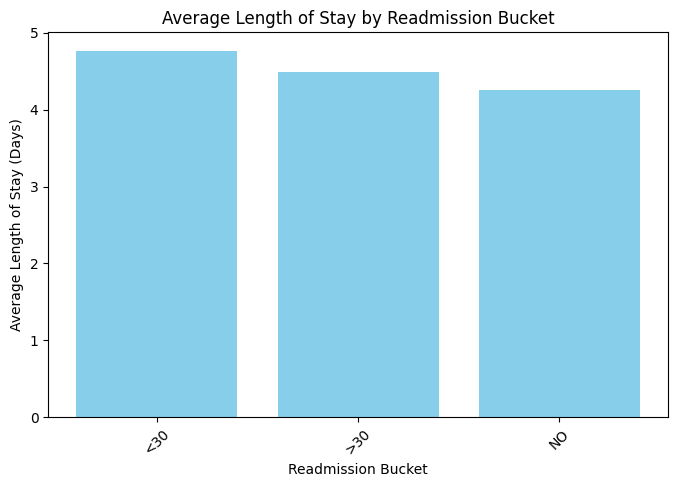

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the average length of stay by readmission bucket
average_length_of_stay = df.groupby('readmitted')['time_in_hospital'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(8, 5))
plt.bar(average_length_of_stay['readmitted'], average_length_of_stay['time_in_hospital'], color='skyblue')
plt.xlabel('Readmission Bucket')
plt.ylabel('Average Length of Stay (Days)')
plt.title('Average Length of Stay by Readmission Bucket')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from openai import OpenAI
import pandas as pd
import json
import matplotlib.pyplot as plt
import io
import contextlib

# Load dataset & semantic layer
df = pd.read_csv("diabetic_data.csv")
semantic_layer = json.load(open("semantic_layer.json"))

# Init OpenAI client
client = OpenAI(api_key="OPENAI_API_KEY")
# Prompt builder
def build_prompt(user_query):
    return f"""
You are a Python data analysis assistant.
You have a Pandas DataFrame called `df` loaded from the Diabetic Data CSV.
Here is the schema and semantic layer:

{json.dumps(semantic_layer, indent=2)}

Rules:
- Only use columns in the schema.
- Use Pandas, NumPy, matplotlib, and scikit-learn if needed.
- Plots: matplotlib only, 1 chart per figure, no style overrides.
- Show print() for textual results; call plt.show() for plots.
- If doing stats, import from scipy or sklearn.
- Do NOT modify files or environment.

User query:
{user_query}
"""

def ask_and_execute(user_query):
    prompt = build_prompt(user_query)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You generate Pandas/NumPy/Matplotlib/Sklearn code to answer data questions."},
                  {"role": "user", "content": prompt}],
        temperature=0
    )
    code = resp.choices[0].message.content
    print(" Generated Code:\n", code)

    # Execute safely
    local_vars = {"df": df, "pd": pd, "plt": plt}
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code, local_vars)
        output = f.getvalue()
        if output.strip():
            print(" Output:\n", output)
    except Exception as e:
        print(" Execution error:", e)

# Example run
ask_and_execute("Which medical specialties have significantly higher average length of stay after controlling for age group?")


 Generated Code:
 To analyze which medical specialties have significantly higher average length of stay after controlling for age group, we can use a linear regression model. This will allow us to assess the impact of medical specialty on the length of stay while controlling for age group.

Here's how you can do this using Python with Pandas and statsmodels:

```python
import pandas as pd
import statsmodels.api as sm

# Assuming df is already loaded with the diabetic data

# Convert 'time_in_hospital' to a numeric type if it's not already
df['time_in_hospital'] = pd.to_numeric(df['time_in_hospital'], errors='coerce')

# Create dummy variables for 'medical_specialty' and 'age'
df = pd.get_dummies(df, columns=['medical_specialty', 'age'], drop_first=True)

# Define the independent variables (X) and the dependent variable (y)
X = df.drop(columns=['time_in_hospital', 'encounter_id', 'patient_nbr', 'readmitted'])
y = df['time_in_hospital']

# Add a constant to the model (intercept)
X = sm.a

In [ ]:
df = pd.get_dummies(df, columns=['medical_specialty', 'age'], drop_first=True)


In [ ]:
from openai import OpenAI
import pandas as pd
import json
import matplotlib.pyplot as plt
import io
import contextlib

# Load dataset & semantic layer
df = pd.read_csv("diabetic_data.csv")
semantic_layer = json.load(open("semantic_layer.json"))

# ---- Preprocessing for statsmodels / ML ----
def preprocess_for_modeling(df):
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [c for c in categorical_cols if c not in ['encounter_id', 'patient_nbr']]

    # One-hot encode
    df_enc = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Ensure numeric
    for col in df_enc.columns:
        df_enc[col] = pd.to_numeric(df_enc[col], errors='coerce')

    # Fill NaNs
    df_enc = df_enc.fillna(0)
    return df_enc

df_encoded = preprocess_for_modeling(df)

# Init OpenAI client
client = OpenAI(api_key="OPENAI_API_KEY")

# Prompt builder
def build_prompt(user_query):
    return f"""
You are a Python data analysis assistant.
You have:
- `df`: original Diabetic Data DataFrame (raw categorical + numeric)
- `df_encoded`: numeric-only DataFrame, one-hot encoded for modeling
Use `df_encoded` for regression, ML, or statsmodels.
Schema and semantic layer:

{json.dumps(semantic_layer, indent=2)}

Rules:
- Only use columns in the schema (or those generated by one-hot encoding if df_encoded).
- Use Pandas, NumPy, matplotlib, statsmodels, or scikit-learn if needed.
- Plots: matplotlib only, 1 chart per figure, no style overrides.
- Show print() for textual results; plt.show() for plots.
- Do NOT modify files or environment.

User query:
{user_query}
"""

def ask_and_execute(user_query):
    prompt = build_prompt(user_query)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You generate Pandas/NumPy/Matplotlib/Sklearn code to answer data questions."},
                  {"role": "user", "content": prompt}],
        temperature=0
    )
    code = resp.choices[0].message.content
    print(" Generated Code:\n", code)

    # Execute safely
    local_vars = {"df": df, "df_encoded": df_encoded, "pd": pd, "plt": plt}
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code, local_vars)
        output = f.getvalue()
        if output.strip():
            print(" Output:\n", output)
    except Exception as e:
        print("Execution error:", e)

# Example high-end query
ask_and_execute("Which medical specialties have significantly higher average length of stay after controlling for age group?")


 Generated Code:
 To analyze which medical specialties have significantly higher average length of stay after controlling for age group, we can use a linear regression model. We'll use `time_in_hospital` as the dependent variable and `medical_specialty` and `age` as independent variables. 

Here's how you can perform this analysis using `statsmodels`:

```python
import pandas as pd
import statsmodels.api as sm

# Assuming df_encoded is already available and contains the necessary columns
# We will create a new DataFrame for the regression analysis
# We need to ensure that 'medical_specialty' and 'age' are treated as categorical variables

# Convert 'medical_specialty' and 'age' to categorical
df_encoded['medical_specialty'] = df_encoded['medical_specialty'].astype('category')
df_encoded['age'] = df_encoded['age'].astype('category')

# Define the independent variables (X) and the dependent variable (y)
X = pd.get_dummies(df_encoded[['medical_specialty', 'age']], drop_first=True)  # One-

Visualization queries

In [ ]:
visualization_queries = [
    "Plot the distribution of length of stay for each readmission category (<30, >30, NO).",
    "Visualize the age group distribution of patients on insulin vs not on insulin.",
    "Show a bar chart of top 10 medical specialties by encounter count.",
    "Create a histogram of number of medications, colored by A1C result category."
]

for q in visualization_queries:
    print(f"\n=== Running: {q} ===")
    ask_and_execute(q)



=== Running: Plot the distribution of length of stay for each readmission category (<30, >30, NO). ===
 Generated Code:
 To plot the distribution of the length of stay (`time_in_hospital`) for each readmission category (`readmitted`), we can use a boxplot to visualize the distribution effectively. Here's how you can do it using Matplotlib and Pandas:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_encoded is already defined and contains the necessary columns
# Create a boxplot for the distribution of time_in_hospital by readmission category
plt.figure(figsize=(10, 6))
df_encoded.boxplot(column='time_in_hospital', by='readmitted', grid=False)
plt.title('Distribution of Length of Stay by Readmission Category')
plt.suptitle('')  # Suppress the default title to clean up the plot
plt.xlabel('Readmission Category')
plt.ylabel('Length of Stay (Days)')
plt.xticks(rotation=45)
plt.show()
```

This code will generate a boxplot showing the distribution of the length

<Figure size 1000x600 with 0 Axes>

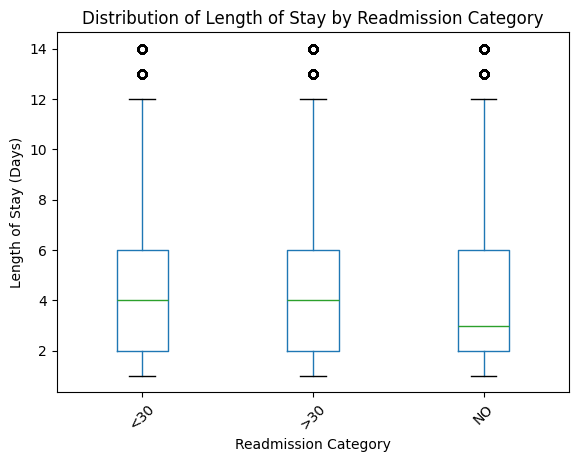

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("diabetic_data.csv")

# Create a boxplot for the distribution of time_in_hospital by readmission category
plt.figure(figsize=(10, 6))
df.boxplot(column='time_in_hospital', by='readmitted', grid=False)
plt.title('Distribution of Length of Stay by Readmission Category')
plt.suptitle('')  # Suppress the default automatic title
plt.xlabel('Readmission Category')
plt.ylabel('Length of Stay (Days)')
plt.xticks(rotation=45)
plt.show()


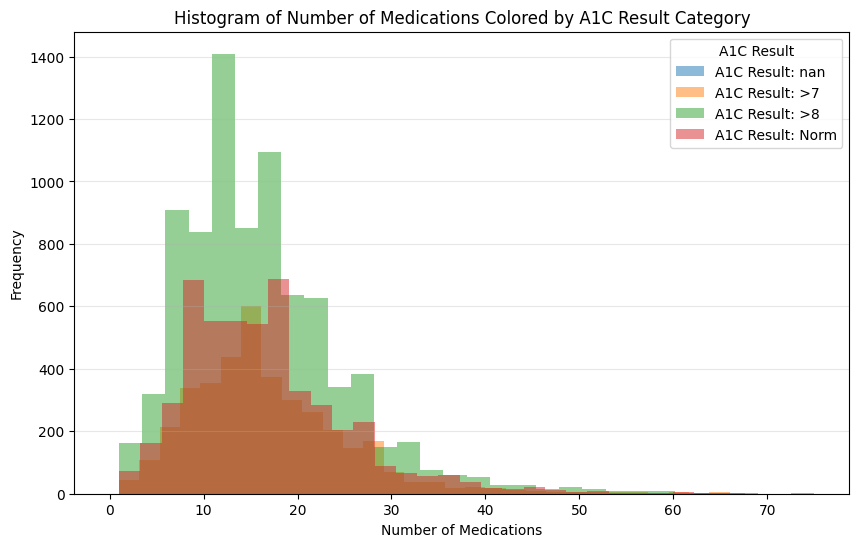

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("diabetic_data.csv")

# Create the histogram
plt.figure(figsize=(10, 6))

# Loop over A1C categories and plot each with its own color
for a1c_category in df['A1Cresult'].unique():
    subset = df[df['A1Cresult'] == a1c_category]['num_medications']
    plt.hist(subset, bins=30, alpha=0.5, label=f'A1C Result: {a1c_category}')

plt.title('Histogram of Number of Medications Colored by A1C Result Category')
plt.xlabel('Number of Medications')
plt.ylabel('Frequency')
plt.legend(title="A1C Result")
plt.grid(axis='y', alpha=0.3)
plt.show()


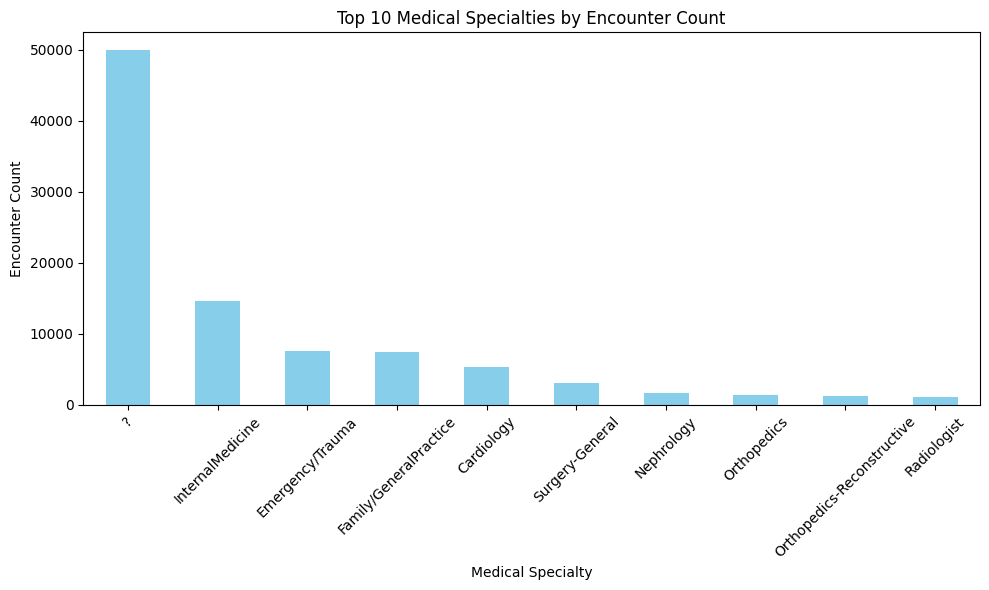

In [ ]:

# Count the number of encounters for each medical specialty
specialty_counts = df['medical_specialty'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
specialty_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Medical Specialties by Encounter Count')
plt.xlabel('Medical Specialty')
plt.ylabel('Encounter Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
ask_and_execute(
    "For each age group, compare the average length of stay between patients readmitted within 30 days and those not readmitted. "
    "Show the results in a grouped bar chart, and annotate the difference on each bar pair."
)


 Generated Code:
 To compare the average length of stay between patients readmitted within 30 days and those not readmitted for each age group, we can follow these steps:

1. Group the data by age and readmission status.
2. Calculate the average length of stay for each group.
3. Create a grouped bar chart to visualize the results.
4. Annotate the differences on each bar pair.

Here's the code to achieve this:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_encoded is already available

# Step 1: Group by age and readmission status, then calculate the average length of stay
avg_length_of_stay = df_encoded.groupby(['age', 'readmitted'])['time_in_hospital'].mean().unstack()

# Step 2: Create a grouped bar chart
avg_length_of_stay.plot(kind='bar', figsize=(10, 6))

# Step 3: Annotate the differences on each bar pair
for i in range(len(avg_length_of_stay)):
    not_readmitted = avg_length_of_stay.iloc[i, 0]
    readmitted = avg_length_of_stay.iloc[i, 1]
    dif

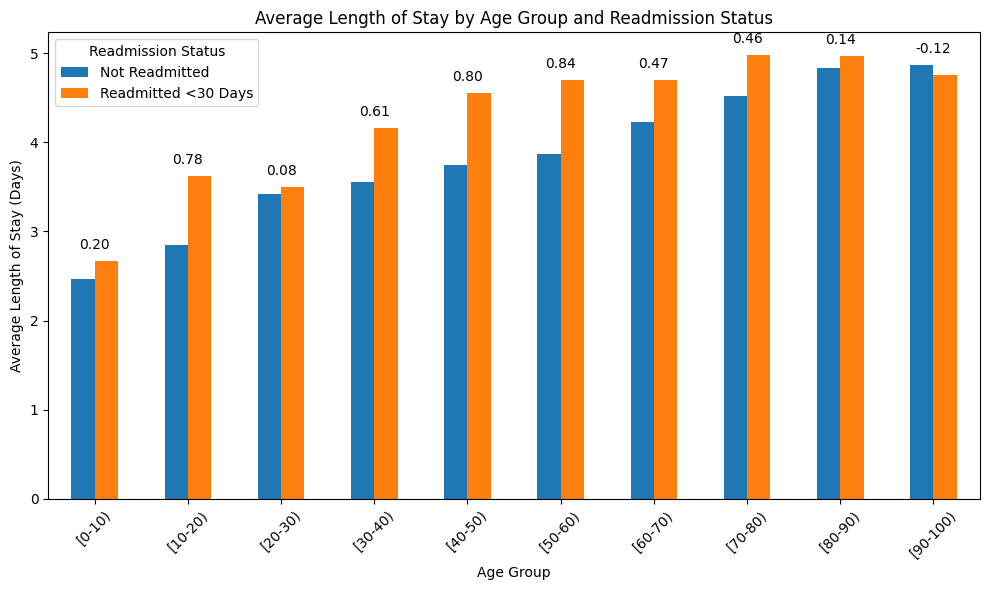

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("diabetic_data.csv")

# Keep only the two readmission buckets we want to compare
sub = df[df['readmitted'].isin(['NO', '<30'])].copy()

# Compute average LOS by age x readmission
avg_los = (
    sub.groupby(['age', 'readmitted'])['time_in_hospital']
       .mean()
       .unstack()                      # columns -> ['<30','NO'] (order may vary)
       .reindex(columns=['NO','<30'])  # force order for plotting: NO first, then <30
       .sort_index()
)

# Plot grouped bars
ax = avg_los.plot(kind='bar', figsize=(10, 6))
plt.title('Average Length of Stay by Age Group and Readmission Status')
plt.xlabel('Age Group')
plt.ylabel('Average Length of Stay (Days)')
plt.xticks(rotation=45)
plt.legend(title='Readmission Status', labels=['Not Readmitted', 'Readmitted <30 Days'])
plt.tight_layout()

# Annotate the difference (<30 - NO) above each pair
for i, age in enumerate(avg_los.index):
    no_val = avg_los.loc[age, 'NO']
    lt30_val = avg_los.loc[age, '<30']
    diff = lt30_val - no_val
    y = max(no_val, lt30_val)
    ax.text(i, y + 0.1, f'{diff:.2f}', ha='center', va='bottom')

plt.show()

